In [3]:
from google.cloud import storage
from google.cloud import bigquery
import gc
from google.cloud.bigquery import SchemaField
from numpy import mean
from numpy import std
from numpy import cov
from numpy import log
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
from jinja2 import Environment, FileSystemLoader, Template

In [4]:
import json  # need it for json.dumps
from altair.vega import v5
from IPython.display import HTML

# Create the correct URLs for require.js to find the Javascript libraries
vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@5'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {paths}
}});
"""

HTML("".join((
    "<script>",
    workaround.format(paths=json.dumps(paths)),
    "</script>",
    "This code block sets up embedded rendering in HTML."
)))

In [5]:
# Define the function for rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        """Render an altair chart directly via javascript.
        
        This is a workaround for functioning export to HTML.
        (It probably messes up other ways to export.) It will
        cache and autoincrement the ID suffixed with a
        number (e.g. vega-chart-1) so you don't have to deal
        with that.
        """
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay defined and keep track of the unique div Ids
    return wrapped


@add_autoincrement
def render(chart, id="vega-chart"):
    # This below is the javascript to make the chart directly using vegaEmbed
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vegaEmbed) {{
        const spec = {chart};     
        vegaEmbed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
    }});
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )


### Part 1: To calculate correlation between events and subscription, we firstly calculate the *uplift* of subscribing probability of those who have experienced those events compared with those who didn't

In this whole test result, we use the data of user within the **first day** playing **PISO2**

For more information, have a look at information gain & entropy: https://medium.com/coinmonks/what-is-entropy-and-why-information-gain-is-matter-4e85d46d2f01

In [6]:
client = bigquery.Client.from_service_account_json('/home/ec2-user/airflow/amanotes-analytics-7354a2a9496e.json')
#filtered meaningful events only
query1 = '''
WITH
  subscriber_sum AS
    (SELECT
      resettable_device_id_or_app_instance_id
      ,MAX(is_subscriber) AS is_subscriber
      ,event_name
    FROM `amanotes-analytics.thi_test.subscriber_by_event_timestamp_rank_1st_day`
    GROUP BY 1,3)
    
  ,var_check AS 
    (SELECT 
      event_name
      ,COUNT (DISTINCT resettable_device_id_or_app_instance_id) AS num_users_true
      ,(SELECT COUNT (DISTINCT resettable_device_id_or_app_instance_id) FROM subscriber_sum) - COUNT (DISTINCT resettable_device_id_or_app_instance_id) AS num_users_false
      ,COUNT (DISTINCT CASE WHEN is_subscriber > 0 THEN resettable_device_id_or_app_instance_id END) AS subscriber_true
      ,(SELECT COUNT (DISTINCT CASE WHEN is_subscriber > 0 THEN resettable_device_id_or_app_instance_id END) FROM subscriber_sum) - COUNT (DISTINCT CASE WHEN is_subscriber > 0 THEN resettable_device_id_or_app_instance_id END) AS subscriber_false
    FROM subscriber_sum
    GROUP BY event_name
    ORDER BY 1)

    ,p_sub AS
    (SELECT
      event_name
      ,SAFE_DIVIDE(subscriber_true, num_users_true) AS p_sub_true
      ,SAFE_DIVIDE(subscriber_false, num_users_false) AS p_sub_false
      ,num_users_true
      ,num_users_false
      ,subscriber_true
      ,subscriber_false
    FROM var_check)

SELECT
  event_name
  ,MAX(p_sub_true) AS p_sub_true
  ,MAX(p_sub_false) AS p_sub_false
  ,SAFE_DIVIDE(MAX(p_sub_true), MAX(p_sub_false)) AS uplift
  ,MAX(num_users_true) AS num_users_true
  ,MAX(num_users_false) AS num_users_false
  ,MAX(subscriber_true) AS subscriber_true
  ,MAX(subscriber_false) AS subscriber_false
FROM p_sub
GROUP BY event_name
'''

In [7]:
q = Template(query1).render()

In [8]:
q_job = client.query(q)
q_result = q_job.result()

In [9]:
df = q_result.to_dataframe()    

In [10]:
tmp_df = df[['event_name','uplift', 'num_users_true']]
tmp_df['num_users_true_log'] = tmp_df['num_users_true'].map(lambda x: log(x + 1))
tmp_df['uplift_log'] = tmp_df['uplift'].map(lambda x: log(x))

/home/ec2-user/miniconda3/envs/airflow3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ec2-user/miniconda3/envs/airflow3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ec2-user/miniconda3/envs/airflow3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel packag

The chart below shows the relation between the **uplift amount** of susbcription probability and **number of user** who have those events.
In other words, if a user experiences an event, let's say "IAP_initial", the chance for them to subscribe increases almost 30 times compared to who don't.

Events should be utilized are those which have both high uplift and number of user 

In [11]:
chart1=alt.Chart(df).mark_point().encode(
    x=alt.X('uplift:Q',scale=alt.Scale(rangeStep=(2))),
    y=alt.Y('num_users_true:Q'),
    color='event_name',
    tooltip=['event_name','uplift', 'num_users_true']
).transform_filter(alt.FieldRangePredicate(field='uplift', range=[1,1000])).interactive()

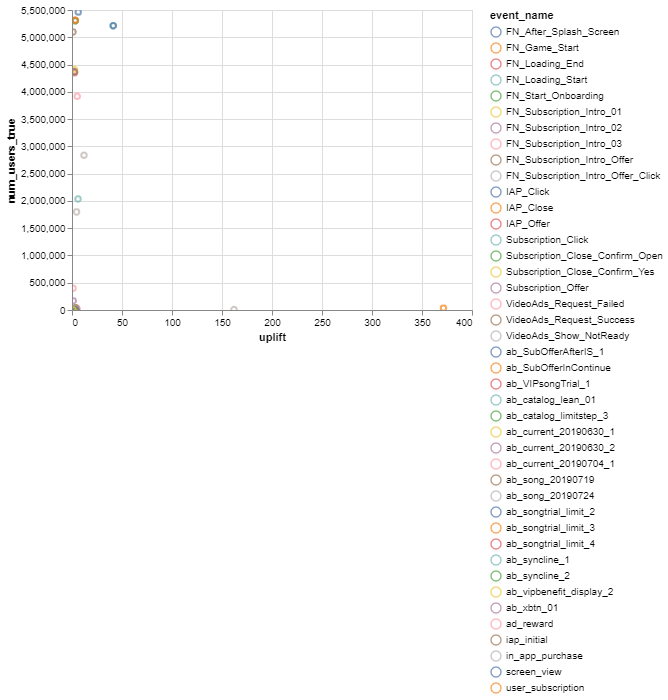

In [12]:
chart1

In [13]:
chart2 = alt.Chart(tmp_df).mark_point().encode(
    x=alt.X('uplift_log:Q',scale=alt.Scale(rangeStep=(2))),
    y=alt.Y('num_users_true_log:Q'),
    color='event_name',
    tooltip=['event_name','uplift_log', 'num_users_true_log']
).transform_filter(alt.FieldRangePredicate(field='uplift_log', range=[0.5,10])).interactive()

Need a better visual? We plot event with log number for clearer relation (the uplift is just relative in this chart)

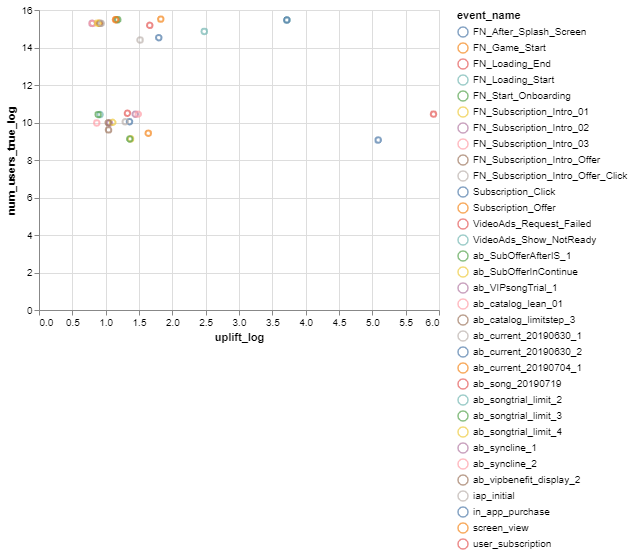

In [15]:
chart2

### Part 2: The correlation between probability of subscription and the frequency of event in the 1st week

In [16]:
query3 = '''
WITH 
  max_data AS
    (SELECT
      COUNT (DISTINCT resettable_device_id_or_app_instance_id) AS max_user
      ,COUNT (DISTINCT CASE WHEN is_subscriber > 0 THEN resettable_device_id_or_app_instance_id END) AS max_subscriber
    FROM `amanotes-analytics.thi_test.subscriber_by_event_timestamp_rank_1st_day`)
  
  ,raw AS
    (SELECT 
      event_name
      ,event_num
      ,MAX(SAFE_DIVIDE(subscriber_count, user_count)) AS p_sub_true
      ,MAX(SAFE_DIVIDE(max_subscriber - subscriber_count, max_user - user_count)) AS p_sub_false
      ,CASE WHEN event_name = 'Notification_FreeSong' THEN SAFE_DIVIDE(MAX(subscriber_count), (SELECT SUM(is_subscriber) FROM `amanotes-analytics.thi_test.subscriber_by_event_timestamp_rank_1st_day` WHERE event_timestamp > 1561865595000))
            ELSE SAFE_DIVIDE(MAX(subscriber_count), (SELECT SUM(is_subscriber) FROM `amanotes-analytics.thi_test.subscriber_by_event_timestamp_rank_1st_day`)) 
      END AS subscriber_rate
    FROM  `amanotes-analytics.thi_test.subscriber_summary_1st_day`, max_data
    WHERE event_name NOT IN ('AName','Ab_Current', 'FN_After_Splash_Screen', 'FN_Game_Start', 'FN_Loading_End', 'FN_Loading_Start', 'FN_Song_Continue', 'FN_Song_End_All', 'FN_Song_Start_All', 'FN_Start_Onboarding', 'FN_Subscription_Intro_01', 'FN_Subscription_Intro_02', 'FN_Subscription_Intro_03', 'FN_Subscription_Intro_04', 'FN_Subscription_Intro_Offer', 'FN_Subscription_Intro_Offer_Click', 'FN_Subscription_Intro_Offer_Close', 'FullAds_Request', 'FullAds_Show_Expired', 'FullAds_Show_NotReady', 'FullAds_Show_Ready_FromSource', 'Subscription_Click', 'Subscription_Close', 'Subscription_Offer', 'Welcome_Open', 'user_subscription', 'user_subscription_Trial2Pay', 'screen_view', 'first_open', 'iap_initial', 'in_app_purchase', 'ab_SubOfferAfterIS_1', 'ab_SubOfferInContinue', 'ab_VIPsongTrial_1', 'ab_artistchoose_03', 'ab_catalog_bgm', 'ab_catalog_lean_01', 'ab_catalog_limitstep_3', 'ab_current_20190628_1', 'ab_current_20190630_1', 'ab_current_20190630_2', 'ab_current_20190704_1', 'ab_increaseprice', 'ab_offer_aftercontinue', 'ab_perfectline_move', 'ab_personalize_tutsong', 'ab_song_20190719', 'ab_song_20190724', 'ab_song_20190909', 'ab_songtrial_limit_2', 'ab_songtrial_limit_3', 'ab_songtrial_limit_4', 'ab_superpower', 'ab_syncline_1', 'ab_syncline_2', 'ab_vip_welcome', 'ab_vipbenefit_display_2', 'ab_xbtn_01', 'ab_xbtn_02', 'createroom_click', 'createroom_end', 'createroom_end_exit', 'createroom_open', 'createroom_play', 'createroom_standby_info_click', 'createroom_standby_info_kick', 'createroom_standby_open', 'createroom_standby_start_click', 'custommatch_click', 'custommatch_joinroom_click', 'dailyquest_click', 'dailyquest_close', 'dailyquest_open', 'dailyquest_song_play', 'download_content_midi_finish', 'download_content_midi_start', 'download_content_mp3_finish', 'download_content_mp3_start', 'error', 'firebase_campaign', 'first_open', 'get_midi_fail', 'get_midi_start', 'get_midi_success', 'get_mp3_fail', 'get_mp3_start', 'get_mp3_success', 'iFullError', 'iVideoError', 'joinroom_end', 'joinroom_end_exit', 'joinroom_open', 'joinroom_play', 'joinroom_standby_exit', 'joinroom_standby_info_click', 'joinroom_standby_open', 'onlmode_click', 'onlmode_open', 'popup_song_suggest_click', 'popup_song_suggest_close', 'popup_song_suggest_open', 'quickmatch_click', 'quickmatch_end', 'quickmatch_end_exit', 'quickmatch_open', 'quickmatch_play', 'quickmatch_standby_exit', 'quickmatch_standby_open', 'createroom_standby_info_click', 'createroom_standby_info_kick', 'createroom_standby_open', 'createroom_standby_start_click', 'custommatch_click', 'custommatch_joinroom_click')
    AND event_num <30
    GROUP BY 1,2)
    
SELECT
  event_name
  ,event_num
  ,p_sub_true
  ,SAFE_DIVIDE(p_sub_true, p_sub_false) AS uplift
  ,subscriber_rate
  ,SAFE_DIVIDE(p_sub_true, p_sub_false) * subscriber_rate *1000 AS event_impact
FROM raw
'''

In [17]:
q_job3 = client.query(query3)
q_result3 = q_job3.result()

In [18]:
df3 = q_result3.to_dataframe()    

In [19]:
chart3=alt.Chart(df3).mark_point().encode(
    x=alt.X('event_num:O'),
    y=alt.Y('uplift:Q'),
    color='event_name',
    tooltip=['event_name','uplift', 'event_num']
).interactive()

Of course, the **more engagement** of our game (the higher frequency of event in the 1st week) shows a **higher subscription chance**.

Event names that highly positively affect subscription probability to name are: 
*VideoAds_Show_NotReady, Video_Ads_Request_Failed, IAP_Click, IAP_Close, IAP_offer...*

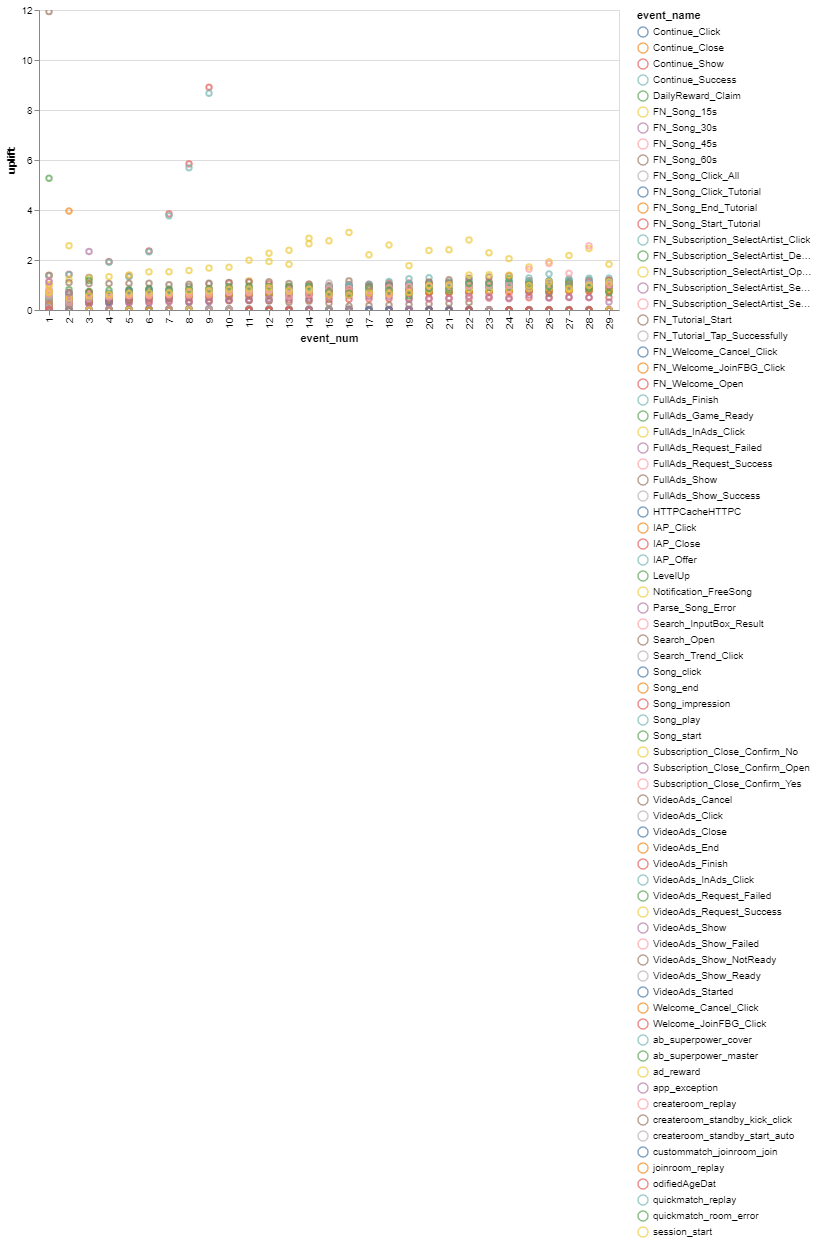

In [20]:
chart3

In [21]:
chart4 = alt.Chart(df3).mark_point().encode(
    x=alt.X('event_num:O'),
    y=alt.Y('subscriber_rate:Q'),
    color='event_name',
    tooltip=['event_name','subscriber_rate', 'event_num']
).interactive()

However, not all user experience events with high subscription uplift. We then take number of user who has that event into consideration as in the chart below

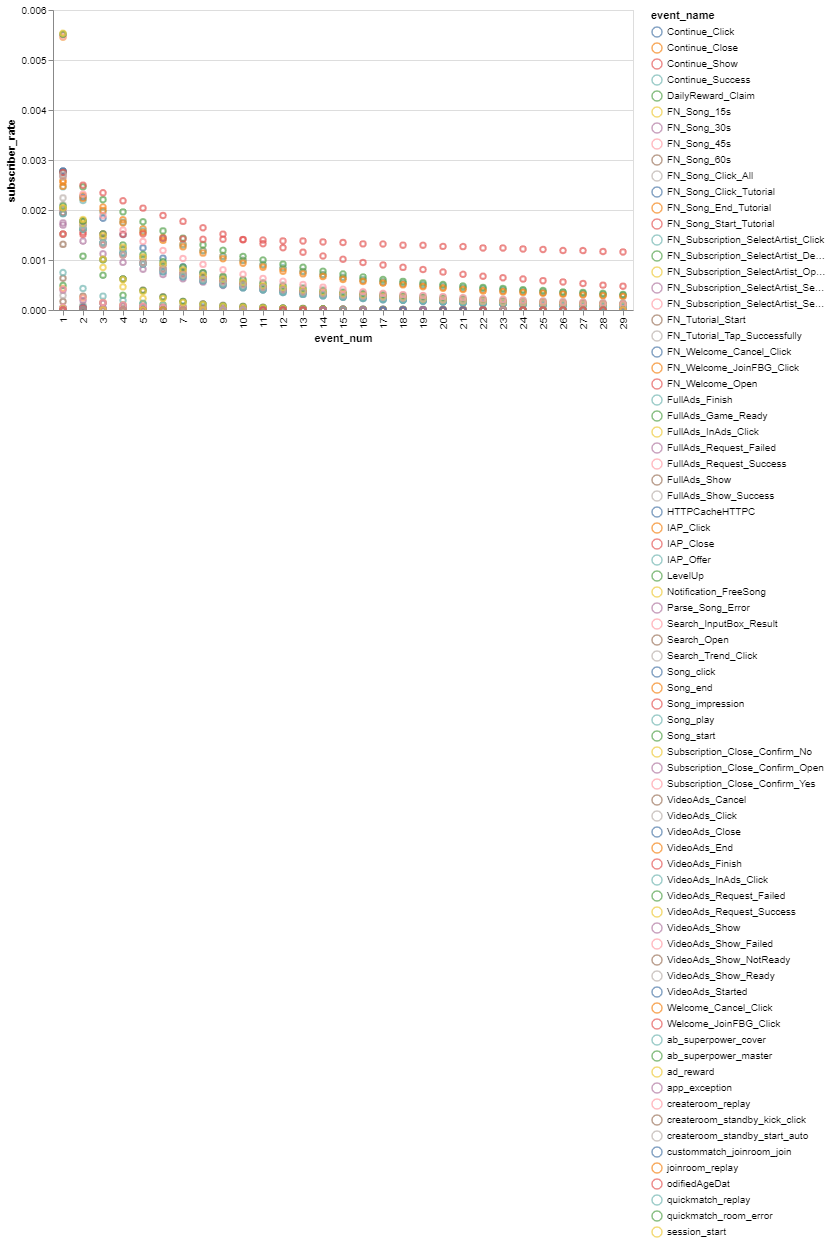

In [22]:
chart4

In [23]:
chart5 = alt.Chart(df3).mark_point().encode(
    x=alt.X('event_num:O'),
    y=alt.Y('event_impact:Q'),
    color='event_name',
    tooltip=['event_name','event_impact', 'event_num']
).interactive()

As seen, those events like "IAP_offer", "IAP_Close" do not really account for big amount in total user. In other words, **most users don't play FN_song_60s for more than 2 times**

Therefore, we use the metric **event_impact = uplift * subscriber rate** to demonstrate the impact of that event on business as a whole

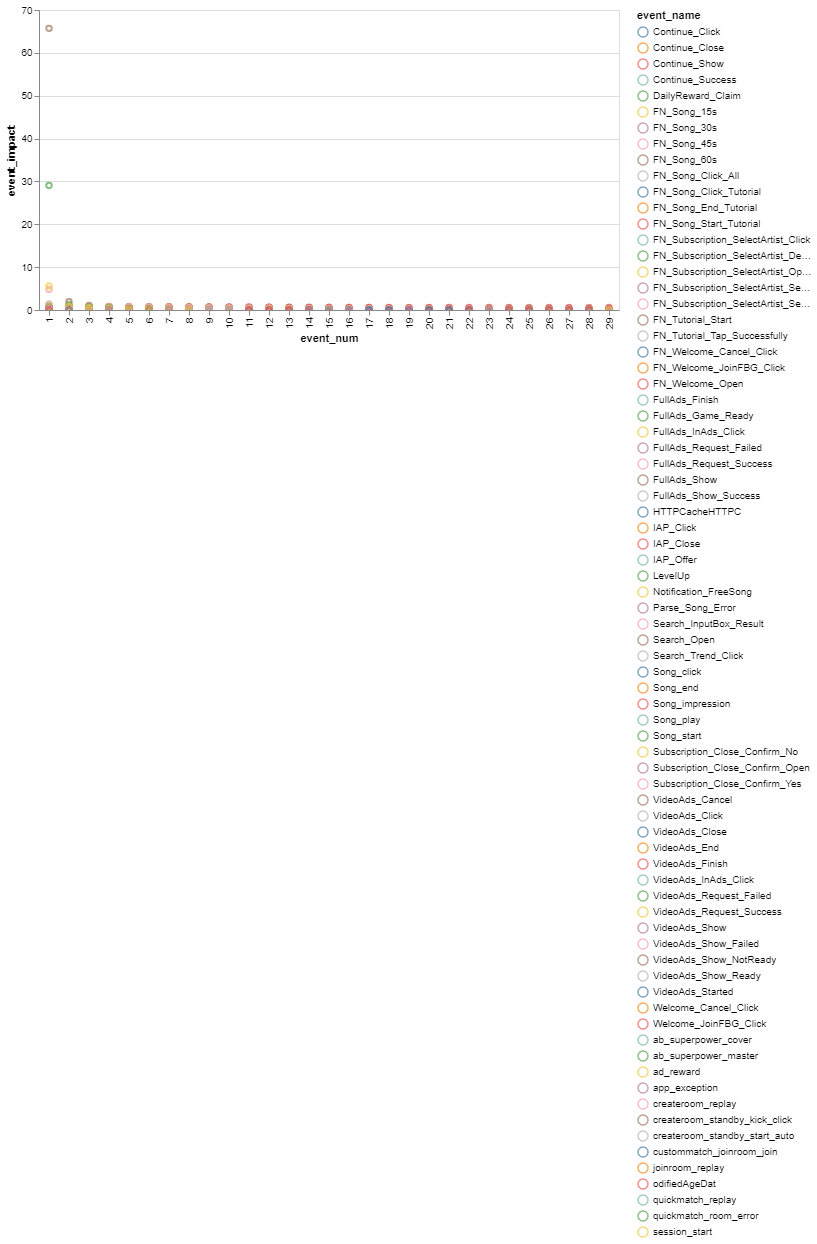

In [24]:
chart5